In [1]:
import matplotlib.pyplot as plt

from src.utils import *
import os
import IPython.display as ipd
import logging
from src.resnet_model import SpectrogramModel
from src.SENet.SENet_model import se_resnet34_custom
import torch.nn as nn
import librosa


logging.getLogger('numba').setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True

In [2]:
config_path = '../config/residualnet_train_config.yaml'
config_res = read_yaml(config_path)
seed_everything(1234)
set_gpu(-1)
plt.style.use('dark_background')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

GPU selected: 0 - NVIDIA TITAN X (Pascal)


In [3]:
win_length = 2048
n_fft = 2048
hop_length = 512
window = 'hann'

In [4]:
# load one file
file_number = 1611480
label = np.array([1])
path_to_original = f'/nas/public/dataset/asvspoof2019/LA/ASVspoof2019_LA_eval/flac/LA_E_{file_number}.flac'
clean_audio, _ = librosa.load(path_to_original, sr=16000)
print('Original Audio Length: ', len(clean_audio))
clean_audio = clean_audio[:47104]  #so that we get the exact length to be fed the model with
print('New Audio Length: ', len(clean_audio))

Original Audio Length:  69107
New Audio Length:  47104


In [5]:
ipd.Audio(clean_audio, rate=16000)

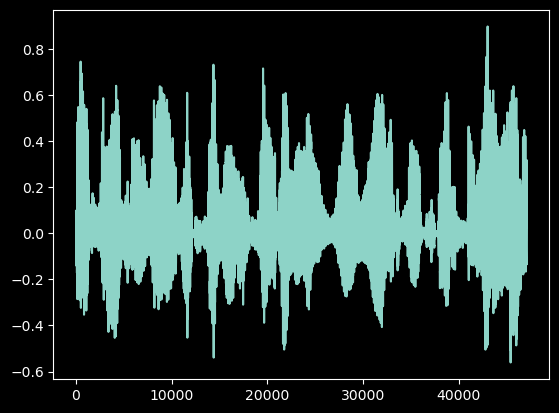

In [13]:
plt.figure()
plt.plot(clean_audio)
plt.show()

In [8]:
s = librosa.stft(clean_audio, n_fft=n_fft, win_length=win_length, hop_length=hop_length, window=window, center=True)
phase = np.angle(s)
phase.shape
mag = np.abs(s)

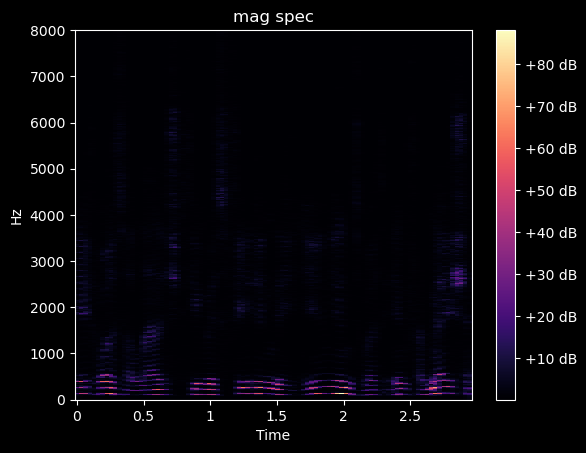

In [9]:
plt.figure()
librosa.display.specshow(mag, sr=16000, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title(f'mag spec')
plt.show()

In [10]:
recon_a = librosa.istft(mag * np.exp(1j * phase), n_fft=n_fft, win_length=win_length, hop_length=hop_length, window=window, center=True)  

In [11]:
ipd.Audio(recon_a, rate=16000)

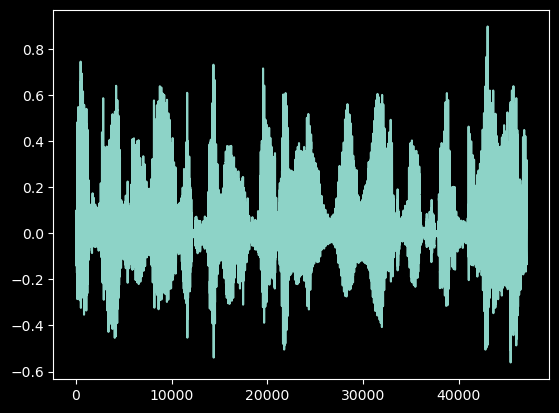

In [12]:
plt.figure()
plt.plot(recon_a)
plt.show()